In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import dill
import sympy
from tqdm import tqdm
from triangle import triangulate
from random import choice, sample

### Load precomputed integrals

In [5]:
lagrange_linear_poisson_matrix = dill.load(open("../calculations/lagrange_linear_poisson_matrix", "rb"))
lagrange_linear_poisson_right_values = dill.load(open("../calculations/lagrange_linear_poisson_right_values", "rb"))

### Initialize the domain

In [12]:
t = np.linspace(0, 2 * np.pi, 50, endpoint=False)

points = np.zeros((0, 2))

for i in range(10):
    
    tmp = np.stack((np.cos(t), np.sin(t))).T * (i+1)/10
    
    points = np.concatenate([points, tmp])



seg = np.array(
    [[j, j + 1] for j in range(points.shape[0] - 1)] + [[points.shape[0] - 1, 0]]
)

### Run triangulation

In [13]:
cndt = triangulate({"vertices": points, "segments": seg}, opts="Dneo1")
points = cndt["vertices"]
triangles = cndt["triangles"]
neighbours = cndt["neighbors"]
vertice_maker_is_boundary = cndt["vertex_markers"]
print(f"Total number of points {points.shape[0]}")

Total number of points 500


### Visualize the triangulation

100%|████████████████████████████████████████████████████████████████| 948/948 [00:00<00:00, 2013.52it/s]


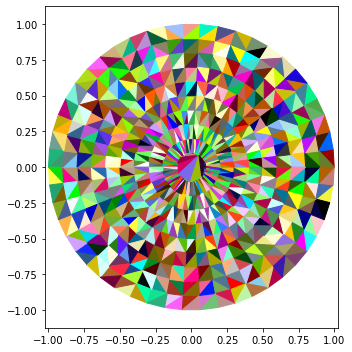

In [14]:
all_colors = (
    list(mcolors.CSS4_COLORS.keys())
    + list(mcolors.XKCD_COLORS.keys())
    + list(mcolors.BASE_COLORS.keys())
)
colors = sample(all_colors, triangles.shape[0])

%matplotlib inline
fig, ax = plt.subplots(figsize=(5, 5))
ax.axis("equal")

for index, triangle in enumerate(tqdm(points[triangles])):
    t1 = plt.Polygon(triangle[:3], color=colors[index])
    fig.gca().add_patch(t1)

    x, y = triangle.mean(axis=0)

ax.set_xlim([points[:, 0].min(), points[:, 0].max()])
ax.set_ylim([points[:, 1].min(), points[:, 1].max()])

fig.tight_layout()
plt.show()

In [9]:
x, y = sympy.symbols("x y")

In [10]:
F = sympy.Float(1)
right_vals = np.zeros((points.shape[0]))
right_vals[:] = sympy.lambdify((x, y), F)(*points.T)

In [ ]:
matrix = np.zeros((points.shape[0], points.shape[0]))
b = np.zeros(points.shape[0])

for idx, element in enumerate(tqdm(triangles)):
    x1, x2, x3 = points[element[0], 0], points[element[1], 0], points[element[2], 0]
    y1, y2, y3 = points[element[0], 1], points[element[1], 1], points[element[2], 1]

    delta = x1 * y2 - x1 * y3 - x2 * y1 + x2 * y3 + x3 * y1 - x3 * y2

    P_1_x = (-y1 + y3) / delta
    P_1_y = (+x1 - x3) / delta

    P_2_x = (+y1 - y2) / delta
    P_2_y = (-x1 + x2) / delta

    arg = [P_1_x, P_2_x, P_1_y, P_2_y, *right_vals[element]]
    
    
    FF = lagrange_linear_poisson_matrix(*arg)
    ff = lagrange_linear_poisson_right_values(*arg)
    
    for local_point in range(3):
        if vertice_maker_is_boundary[element[local_point]] == True:
            matrix[element[local_point], element[local_point]] = 1
            b[element[local_point]] *= 0
        else:
            for i in range(3):
                matrix[element[local_point], element[i]] += 2 * FF[local_point, i]
                    
            b[element[local_point]] -= 2 * ff[local_point]

In [ ]:
c = np.linalg.solve(matrix, b)

In [ ]:
%matplotlib widget
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection="3d")
orig = (points[:, 0] ** 2 + points[:, 1] ** 2 - 1) / 4
ax.plot_trisurf(points[:, 0], points[:, 1], c, cmap="magma")
plt.show()